One of the requests from the SAC was to evaluate the effect of confining u band visits to within a few days of new moon. The motivation behind this was multi-fold:
* constraining u band visits to a few days around new moon could improve the u band visit depth
* clustering u band around new moon (and y band around full moon) could let sequences of *griz* occur more frequently in the time in-between (from the DESC WFD white paper) and allow more time available for *gri/zy* DD sequences (from the DESC DD white paper)

Other relevant requirements include 
* achieving the desired *u* band depth across the sky for photo-z calculations. The SRD defines this as *u*=26.1, equivalent to about 56 visits under ideal conditions. 
* achieving the desired *u* band depth in Deep Drilling sequences. The AGN DD white paper (Brandt et al) request a depth of *u*=28.3 in each DD field, equivalent to approximately 2700 visits under ideal conditions.

**Executive Summary:** 
In FBS 1.3, we will redo these runs with updates to the *u* band DD sequences, add a run with even tighter constraints in *u* band availability around new moon, and test adding higher priority to *u* band visits when available (particularly in areas where the coadded depth is lagging). 
The FBS 1.2 runs show that we should use a smaller default value for when to swap filters (current default is 60% illumination; either 15% or 30% illumination would be a better default). 

**Details:**
A very rough back-of-the-envelope estimate suggests that reaching DD depths of *u*=28.3 for 5 DD fields and 26.1 visits per point of the sky across the equivalent of the WFD, would require a total of about 144 nights (if a night is 10 hours long), so constraining u band visits more tightly to new moon should be possible (even if the u band filter is only available for a few nights around new moon). 

With the FBS 1.2 set of runs, we have addressed this request with a series of 3 simulations where the *u* band filter was swapped with *z* band at different levels of lunar illumination (equivalent to moon phase in this case, with 'phase' == 'percent of lunar surface illuminated', ranging between 0-100). These runs include filter swaps at 15%, 30% and 60% lunar illumination, corresponding to 3.5 (i.e. 3 or 4), 5, and 8 days from new moon. 

None of these runs saturate the new moon time with *u* band visits (and you wouldn't expect this, as twilight will still have non-*u* band visits), although there is a significantly higher fraction of visits in *u* band when the availability is limited to +/- 3-4 days around new moon. 

The distribution of individual image depths doesn't change significantly between these runs. The scheduler appears to be doing a good job at taking *u* band images under appropriate conditions. Thus the first concern - to constrain visits to near new moon to improve the visit depth - is already taken care of through the scheduler basis functions.

The second concern - clustering the *u* band visits to improve the cadence of *grizy* - is slightly more complicated to evaluate.  The obvious problem is that in these runs, *u* band is being swapped with *z* band, so when *u* is in the telescope for longer there are necessarily longer gaps in *z* band. Pushing these gaps to 16 nights is likely problematic given the constraints stated in the DESC WFD white paper (maximum night gaps of 14 nights). There is a complementary difference in the spacing of the *u* band visits, however the *u* band does not have as strong constraints on the inter-night visit gaps. The distribution of visits in other filters is similar across these runs. 

Looking at the *u* band visits and coadded depth across the sky[++], we see that the runs with a shorter availability for the *u* filter resulted in a patchier distribution of visits and coadded depth. The number of visits were fewer in the fields overhead during summer (this is the area 'left' of the galactic plane and 'south' of the NES), although generally hit the 56 visit requirement - the coadded depth was patchier and often came a bit short of the desired 26.1 coadded magnitude. With a longer time available to take *u* band visits, the coadded depth improved - with almost 40\% more area covered to the desired depth (13k vs. 9k sq deg). This suggests that we should try running the simulator to prefer *u* band visits a bit more strongly, particularly when the available time is more limited. 

Looking at the *u* band visits for the DD fields exposed a small 'feature' in the DD sequences that was limiting the overall number of visits too strongly. This can (also) be seen in the way that some DD fields have many fewer *u* band visits than other fields. We will reconfigure the *u* band DD sequences so that the final coadded depth is more uniform between fields and deeper overall (likely by adjusting the number of visits in *u* band in each sequence, but also by relaxing the inter-night revisit gap requirement on the DD scripted survey). 

(++ note that in FBS 1.2 the reported *u* band depth per visit is close to 0.2 magnitudes shallower than the expected depth, due to a bug that reported the depth for a 2x15s visit instead of a 1x30s visit. The values shown here for individual image and coadded *u* band depth are thus about 0.2 magnitudes shallower than they should be). 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ephem
from astropy.time import Time, TimeDelta
import datetime
import pandas as pd
import healpy as hp

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as mb
import lsst.sims.maf.plots as plots
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.batches as batches
import lsst.sims.maf.runComparison as runComparison
import lsst.sims.utils as simUtils

Loading BokehJS ...

In [3]:
# Scheduler uses pyephem to determine moon phase. What is the relationship between phase and illumination?
moon = ephem.Moon()
obs = ephem.Observer()
site = simUtils.Site('LSST')
obs.lat = site.latitude
obs.lon = site.longitude

In [4]:
# new moon is about here .. 
t = Time('2022-10-10', format='iso')
t0 = Time('2022-10-10', format='iso')
times = []
phases = []
while t < Time('2022-11-30', format='iso'):
    obs.date = t.datetime
    moon.compute(obs)
    times.append(t.mjd)
    phases.append(moon.phase)
    t = t + TimeDelta(2/24., format='jd')
times = np.array(times)
phases = np.array(phases)

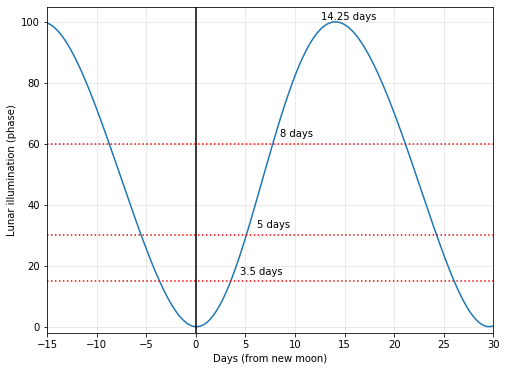

In [5]:
plt.figure(figsize=(8,6))
plt.plot(times - t0.mjd - 15.4, phases)
plt.grid(True, alpha=0.3)
plt.xlabel("Days (from new moon)")
plt.ylabel("Lunar illumination (phase)")
plt.axhline(15, color='r', linestyle=':')
plt.axhline(30, color='r', linestyle=':')
plt.axhline(60, color='r', linestyle=':')
plt.axvline(0, color='k', linestyle='-')
#plt.axvline(3.5, color='k', linestyle=':')
#plt.axvline(5, color='k', linestyle=':')
#plt.axvline(14.25, color='k', linestyle=':')
plt.figtext(.46, .26, '3.5 days')
plt.figtext(.49, .37, '5 days')
plt.figtext(.53, .58, '8 days')
plt.figtext(.6, .85, '14.25 days')
plt.xlim(-15, 30)
plt.ylim(-2, 105)
plt.savefig('MoonPhaseDays.png')

In [6]:
# Back of the envelope  -- how much time do we need to cover sky in u band 

## WFD-like coverage

one_field = 56 * (30+4+6)/60/60 # 56 visits * 34s 
print(f'time for one field: {one_field} (hours)')

# assume there are roughly 20k sq deg / 10 sq deg (per field) = 2000 fields
n_fields = 20000/10
print(f'time for {n_fields} fields: {one_field * n_fields / 10} (10 hour nights)')

## DD fields .. assume need ~3500 visits, based on u band depths and visits (from calculation below)
# if just look at scaling relationships, then in theory (if always had good seeing and good sky), 
# could complete u band to 28.3 in just 2700 visits.
n_exp = 3500
n_dd = 5
dd_field = n_exp * (30+4+6)/60/60
print(f'time for {1} fields: {dd_field} (hours)')
print(f'time for {n_dd} fields: {dd_field * n_dd / 10} (10 hour nights)')

ndays = (n_fields * one_field + dd_field * n_dd) / 10
print(f'Total days {ndays}')
day_per_month = [4, 3.8*2, 5*2, 8*2]
for d in day_per_month:
    print(f'Total months ({d} days/month) {ndays/d}')

time for one field: 0.6222222222222222 (hours)
time for 2000.0 fields: 124.44444444444446 (10 hour nights)
time for 1 fields: 38.88888888888889 (hours)
time for 5 fields: 19.444444444444446 (10 hour nights)
Total days 143.8888888888889
Total months (4 days/month) 35.97222222222223
Total months (7.6 days/month) 18.9327485380117
Total months (10 days/month) 14.388888888888891
Total months (16 days/month) 8.993055555555557


In [7]:
runs = ['fc1exp_pairsmix_ilim15_10yrs', 'fc1exp_pairsmix_ilim30_10yrs', 'fc1exp_pairsmix_ilim60_10yrs']

outDir = 'u_swap'

opsdb = {}
for r in runs:
    opsdb[r] = db.OpsimDatabase(f'fbs_db/{r}.db')

In [8]:
constraint = ''
simdata = {}
for r in runs:
    cols = ['observationStartMJD', 'observationStartLST', 'fiveSigmaDepth', 
            'filter', 'note', 'moonPhase', 'fieldRA', 'fieldDec']
    simdata[r] = opsdb[r].fetchMetricData(cols, sqlconstraint=constraint)

In [9]:
simdata_pd = {}
for r in runs:
    simdata_pd[r] = pd.DataFrame(simdata[r])

In [10]:
# MetricBundles to map the number of u band visits and coadded depth across the sky
m = {}
m['count'] = metrics.CountMetric('observationStartMJD')
m['coadd'] = metrics.Coaddm5Metric()
s = slicers.HealpixSlicer()
constraint = 'filter = "u"'
metadata = 'u band'

bundles = {}
for r in runs:
    bundles[r] = {}
    for metric in m:
        bundles[r][metric] = mb.MetricBundle(m[metric], s, constraint, metadata=metadata, runName=r)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [11]:
# MetricBundles to generate histograms of the u band individual image depth
depth_hist ={}
m = metrics.CountMetric('fiveSigmaDepth')
constraint = 'filter == "u"'
metadata = 'u band'
bins = np.arange(22.5, 25.0, 0.025)
for r in runs:
    s = slicers.OneDSlicer(sliceColName='fiveSigmaDepth', bins=bins)
    depth_hist[r] = mb.MetricBundle(m, s, constraint, metadata=metadata, runName=r)

In [12]:
for r in runs:
    g = mb.MetricBundleGroup(bundles[r], opsdb[r], outDir=outDir)
    g.runAll()
    g = mb.MetricBundleGroup({r: depth_hist[r]}, opsdb[r], outDir=outDir)
    g.runAll()

Querying database SummaryAllProps with constraint filter = "u" for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'fiveSigmaDepth']
Found 145031 visits
Running:  ['count', 'coadd']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter == "u" for columns ['fiveSigmaDepth']
Found 145031 visits
Running:  ['fc1exp_pairsmix_ilim15_10yrs']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "u" for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'fiveSigmaDepth']
Found 153467 visits
Running:  ['count', 'coadd']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter == "u" for columns ['fiveSigmaDepth']
Found 153467 visits
Running:  ['fc1exp_pairsmix_ilim30_10yrs']
Completed metric generation.
R

In [13]:
ph = plots.PlotHandler(outDir=outDir)

1

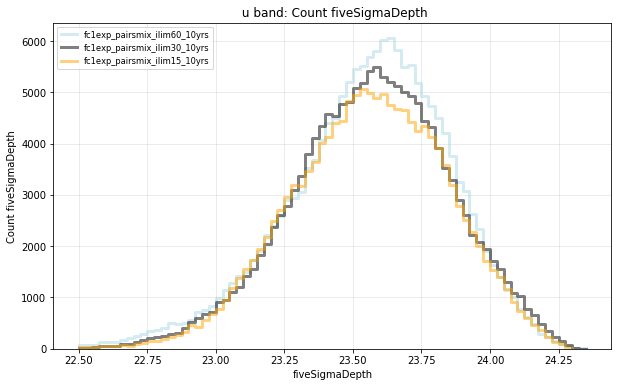

In [14]:
ph.setMetricBundles(depth_hist)
plotDict={'figsize': (10,6), 'title': "Histogram of individual image u band depth", 
            'legendloc': 'upper left'}
plotDicts = [{'color': 'lightblue',  'linewidth': 3}, 
             {'color': 'k',  'linewidth': 3},
             {'color': 'orange',  'linewidth': 3}]
plotDicts[0].update(plotDict)
ph.plot(plotFunc=plots.OneDBinnedData(), plotDicts=plotDicts)

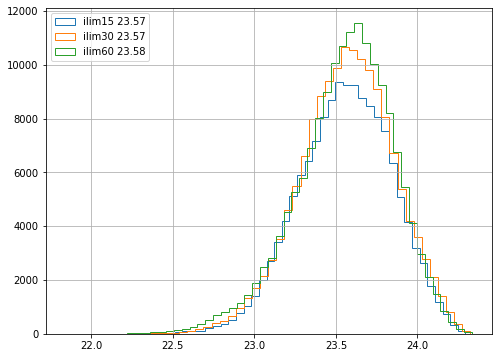

In [15]:
# Let's check ..
plt.figure(figsize=(8,6))
for r in runs:
    rn = r.replace('fc1exp_pairsmix_', '').replace('_10yrs', '')
    u = simdata_pd[r].query('filter=="u"')
    u['fiveSigmaDepth'].hist(bins=50, histtype='step', label=rn + ' %.2f' % u.fiveSigmaDepth.median())
plt.legend(fancybox=True, loc='upper left', numpoints=1)

In [16]:
# Actually ... let's add some summary stats to the skymaps.
for r in runs:
    for md in bundles[r]:
        bundles[r][md].setSummaryMetrics(batches.extendedSummary())
        bundles[r][md].computeSummaryStats()

In [17]:
o = []
for r in runs:
    o.append(pd.DataFrame(bundles[r]['count'].summaryValues, 
                          index=[r.replace('fc1exp_pairsmix_', '').replace('_10yrs', '').replace('ilim', 'Illum ')]))
cols = ['Min', '25th%ile', 'Mean', 'Median', '75th%ile', 'Max', ]
pd.concat(o)[cols].T

,Illum 15,Illum 30,Illum 60
Min,1.000000,1.000000,1.000000
25th%ile,54.000000,55.000000,58.000000
Mean,59.386335,62.798245,66.956338
Median,62.000000,63.000000,66.000000
75th%ile,67.000000,68.000000,71.000000
Max,1788.000000,3251.000000,3402.000000


In [18]:
o = []
for r in runs:
    o.append(pd.DataFrame(bundles[r]['coadd'].summaryValues, 
                          index=[r.replace('fc1exp_pairsmix_', '').replace('_10yrs', '').replace('ilim', 'Illum ')]))
cols = ['Min', '25th%ile', 'Mean', 'Median', '75th%ile', 'Max', ]
pd.concat(o)[cols].T

,Illum 15,Illum 30,Illum 60
Min,22.181656,22.318727,22.004103
25th%ile,25.728216,25.764568,25.787233
Mean,25.753742,25.783810,25.803447
Median,25.867756,25.900715,25.919637
75th%ile,25.948631,25.968181,25.986368
Max,27.592408,27.928824,28.064792


/Users/lynnej/lsst_stack/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/lynnej/lsst_stack/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/lynnej/lsst_stack/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
 

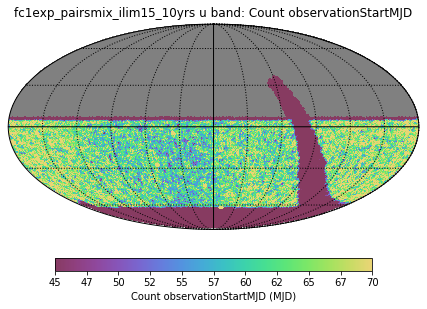

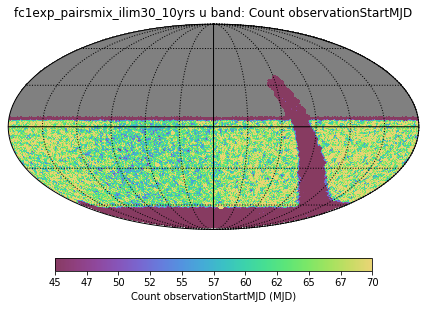

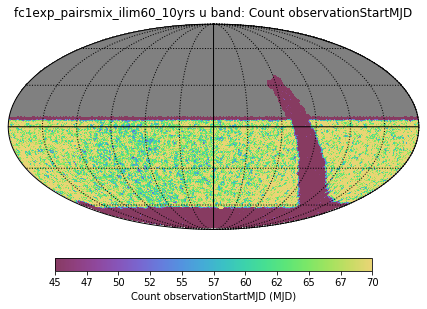

In [19]:
# Goal number of visits = 56
plotDict = {'colorMin': 45, 'colorMax': 70}
for r in runs:
    ph.setMetricBundles([bundles[r]['count']])
    ph.plot(plotFunc=plots.HealpixSkyMap(), plotDicts=plotDict)

/Users/lynnej/lsst_stack/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/lynnej/lsst_stack/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/lynnej/lsst_stack/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
 

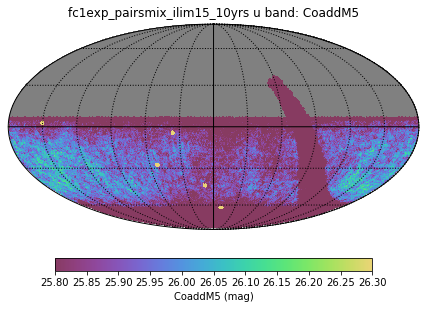

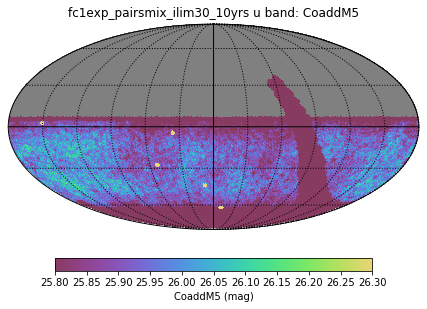

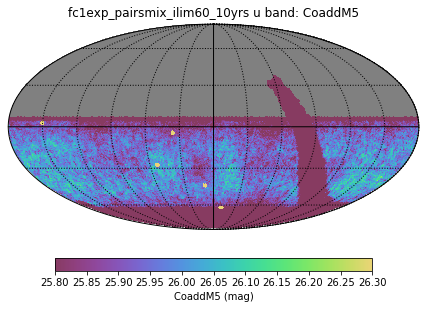

In [20]:
# goal depth = 26.1
# (FBS 1.2 runs should increase u band depth per visit by about 0.2)
plotDict = {'colorMin': 25.8, 'colorMax': 26.3}
for r in runs:
    ph.setMetricBundles([bundles[r]['coadd']])
    ph.plot(plotFunc=plots.HealpixSkyMap(), plotDicts=plotDict)

In [21]:
# But maybe we want to know: how much area was part of 'wfd' and did not reach coadd_u = 26.1 (25.9 here, b/c bug) 
#  .. alternatively how much area reached 26.1? 
nvisits = {}
area = {}
for r in runs:
    mvals = bundles[r]['coadd'].metricValues
    nside = bundles[r]['coadd'].slicer.nside
    area[r] = len(np.where(mvals.filled(0) >= 25.9)[0]) * hp.nside2pixarea(nside, degrees=True)
    mvals = bundles[r]['count'].metricValues
    nvisits[r] = len(np.where(mvals.filled(0) >= 56)[0]) * hp.nside2pixarea(nside, degrees=True)
o = pd.DataFrame([nvisits, area], index=['nvisits area', 'coadd area'])
o.T / o.T.loc['fc1exp_pairsmix_ilim15_10yrs']

,nvisits area,coadd area
fc1exp_pairsmix_ilim15_10yrs,1.000000,1.000000
fc1exp_pairsmix_ilim30_10yrs,1.035771,1.256547
fc1exp_pairsmix_ilim60_10yrs,1.067491,1.406867


In [22]:
# Check on DD observations
k = runs[0]
ddfields = simdata_pd[k].loc[simdata_pd[k]['note'].str.startswith('DD')].note.unique()
print(ddfields)

['DD:ELAISS1' 'DD:ECDFS' 'DD:XMM-LSS' 'DD:290' 'DD:u,ELAISS1' 'DD:u,290'
 'DD:u,ECDFS' 'DD:u,XMM-LSS' 'DD:COSMOS' 'DD:u,COSMOS']


In [23]:
uddfields = []
for d in ddfields:
    if d[3] == 'u':
        uddfields.append(d)
print(uddfields)

['DD:u,ELAISS1', 'DD:u,290', 'DD:u,ECDFS', 'DD:u,XMM-LSS', 'DD:u,COSMOS']


In [24]:
m5m = metrics.Coaddm5Metric()

In [25]:
count_u = {}
coadd_u = {}
for r in runs:
    rn = r.replace('fc1exp_pairsmix_', '').replace('_10yrs', '').replace('ilim', 'Illum ')
    count_u[rn] = {}
    coadd_u[rn] = {}
    for ddf in uddfields:
        s = simdata_pd[r].query('note == @ddf')
        count_u[rn][ddf] = len(s) 
        coadd_u[rn][ddf] = m5m.run(s)

In [26]:
pd.DataFrame(count_u)

,Illum 15,Illum 30,Illum 60
"DD:u,ELAISS1",1092,2079,3281
"DD:u,290",726,1295,2079
"DD:u,ECDFS",1714,3178,3327
"DD:u,XMM-LSS",1211,2247,3265
"DD:u,COSMOS",1421,2590,3206


In [27]:
# Do the u band DD fields reach the desired coadded depth? 
# AGN white paper: u=28.3. DESC white paper: 26.8
pd.DataFrame(coadd_u)

,Illum 15,Illum 30,Illum 60
"DD:u,ELAISS1",27.434422,27.808381,28.052296
"DD:u,290",27.106095,27.408551,27.653017
"DD:u,ECDFS",27.560829,27.912816,27.898625
"DD:u,XMM-LSS",27.383279,27.724085,27.915011
"DD:u,COSMOS",27.397545,27.724804,27.815033


In [28]:
o = pd.DataFrame(count_u)
cols = o.columns.values
cols = [c + ' Nvisits' for c in cols]
o.columns = cols
o
p = pd.DataFrame(coadd_u)
cols = p.columns.values
cols = [c + ' Coadd u' for c in cols]
p.columns = cols
o.join(p)

,Illum 15 Nvisits,Illum 30 Nvisits,Illum 60 Nvisits,Illum 15 Coadd u,Illum 30 Coadd u,Illum 60 Coadd u
"DD:u,ELAISS1",1092,2079,3281,27.434422,27.808381,28.052296
"DD:u,290",726,1295,2079,27.106095,27.408551,27.653017
"DD:u,ECDFS",1714,3178,3327,27.560829,27.912816,27.898625
"DD:u,XMM-LSS",1211,2247,3265,27.383279,27.724085,27.915011
"DD:u,COSMOS",1421,2590,3206,27.397545,27.724804,27.815033


In [29]:
# Hourglass plots match  - 
# http://astro-lsst-01.astro.washington.edu:8081/filter_changer/fc1exp_pairsmix_ilim15_10yrs/fc1exp_pairsmix_ilim15_10yrs_Hourglass_year_1-2_HOUR_Hourglass.pdf
# suggests that some months are u-band only, but other months are not. 

In [30]:
m = np.arange(0, 100, 3)
frac = {}
for r in runs:
    frac[r] = np.zeros(len(m))
    for i in range(len(m)-1):
        mi = m[i]
        mo = m[i+1]
        tmp = simdata_pd[r].query('moonPhase <= @mo and moonPhase > @mi')
        if len(tmp) == 0:
            frac[r][i] = 0
        else:
            frac[r][i] = len(tmp.query("filter == 'u'")) / len(tmp)

Text(0, 0.5, 'Fraction of visits in u band')

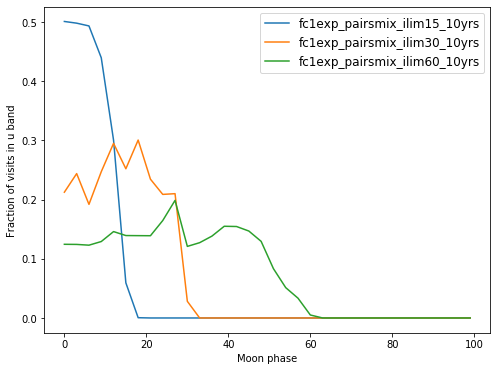

In [31]:
plt.figure(figsize=(8,6))
for r in runs:
    plt.plot(m, frac[r], label=r)
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.xlabel('Moon phase')
plt.ylabel('Fraction of visits in u band')

In [32]:
# Look into the grizy cadences 
sql = 'note not like "DD%" and fieldDec > -62 and fieldDec < 2'
metadata = 'wfd-like'
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']

bins = np.arange(1, 30, 1)
s = slicers.HealpixSlicer(nside=64)

deltaBundles = {}
for r in runs:
    deltaBundles[r] = {}
    for f in filterlist:
        # Histogram of the number of nights between visits, per filter
        sqls = sql + ' and filter == "%s"' % f
        md = 'wfd-like %s band' % f
        metric = metrics.NightgapsMetric(bins=bins, nightCol='night', metricName='DeltaNight Histogram')
        plotDict = {'bins': bins, 'xlabel': 'dT (nights)'}
        plotFunc = plots.SummaryHistogram()
        bundle = mb.MetricBundle(metric, s, sqls, plotDict=plotDict, runName=r,
                                 metadata=md, plotFuncs=[plotFunc])
        deltaBundles[r][f] = bundle

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [33]:
for r in runs:
    g = mb.MetricBundleGroup(deltaBundles[r], opsdb[r])
    g.runAll()

Querying database SummaryAllProps with constraint note not like "DD%" and fieldDec > -62 and fieldDec < 2 and filter == "z" for columns ['night', 'fieldDec', 'fieldRA']
Found 350684 visits
Running:  ['z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint note not like "DD%" and fieldDec > -62 and fieldDec < 2 and filter == "r" for columns ['night', 'fieldDec', 'fieldRA']
Found 379068 visits
Running:  ['r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint note not like "DD%" and fieldDec > -62 and fieldDec < 2 and filter == "i" for columns ['night', 'fieldDec', 'fieldRA']
Found 371665 visits
Running:  ['i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint note not like "DD%" and fieldDec > -62 and fieldDec < 2 and

In [34]:
filtercolors = {'u': 'cyan', 'g': 'g', 'r': 'orange', 'i': 'r', 'z': 'm', 'y': 'b'}
for r in runs:
    for f in filterlist:
        plotDict = {'color': filtercolors[f]}
        deltaBundles[r][f].setPlotDict(plotDict)

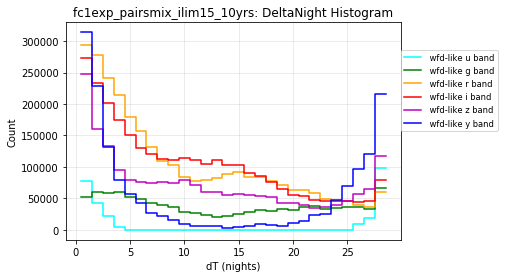

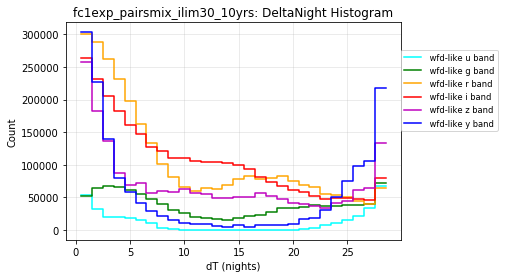

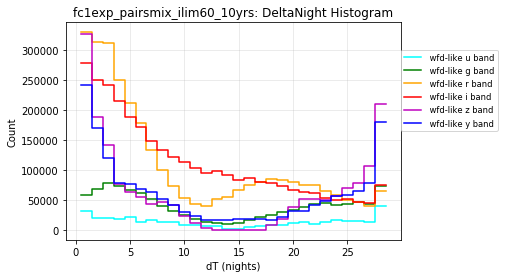

In [35]:
for r in runs:
    ph.setMetricBundles(deltaBundles[r])
    ph.plot(plotFunc=plots.SummaryHistogram(), plotDicts={'legendloc': (1.0, .5)})

In [37]:
filtercolors = {'u': 'cyan', 'g': 'g', 'r': 'orange', 'i': 'r', 'z': 'm', 'y': 'b'}
runColors = {'fc1exp_pairsmix_ilim15_10yrs': 'green',
            'fc1exp_pairsmix_ilim30_10yrs': 'orange',
            'fc1exp_pairsmix_ilim60_10yrs': 'blue'}
for r in runs:
    for f in filterlist:
        plotDict = {'color': runColors[r]}
        deltaBundles[r][f].setPlotDict(plotDict)

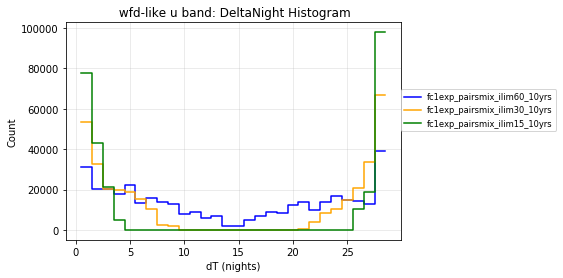

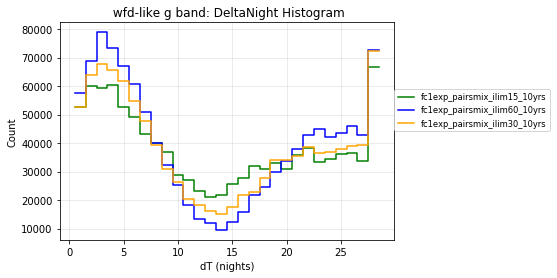

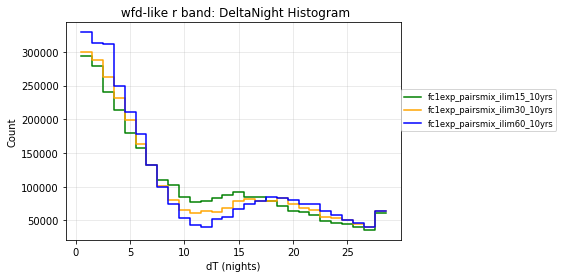

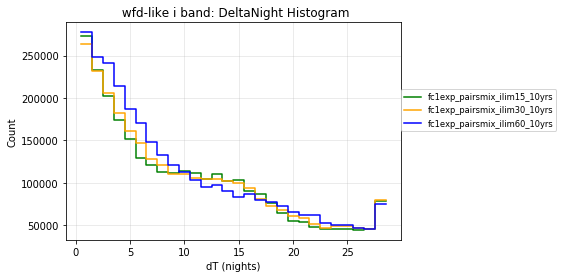

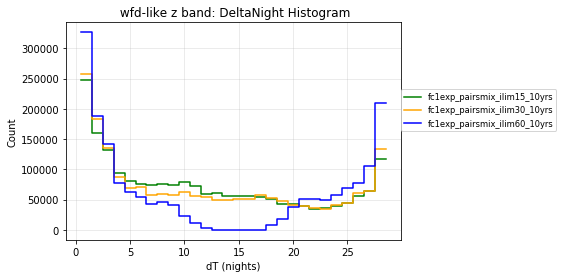

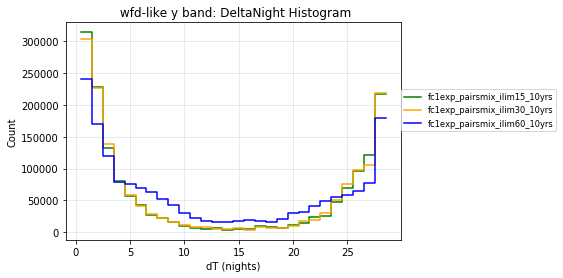

In [39]:
for f in filterlist:
    ph.setMetricBundles({0: deltaBundles[runs[0]][f],
                         1: deltaBundles[runs[1]][f], 
                         2: deltaBundles[runs[2]][f]})
    ph.plot(plotFunc=plots.SummaryHistogram(), 
            plotDicts={'legendloc': (1.0, .5)})